In [15]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from geopandas import GeoSeries, GeoDataFrame
import rasterio
from rasterio.mask import mask
import shapely
from rasterio.plot import show
from rasterio.merge import merge
import cv2 as cv

In [2]:
shp = gpd.read_file("./data/dissolved/0812_dis.shp")
rst = rasterio.open("./data/2017/nir/2017.07.01.tif")
copy = rasterio.open("./data/2017/nir/2017.07.01.tif")
band1 = rst.read(1)

In [3]:
band1 = rst.read(1)
x = 500
y = 500
inc = 50
img24 = band1[x:(x+inc), y:(y+inc)]

In [4]:
# 0, 0
t1 = rst.transform * (x, y)
t2 = rst.transform * (x, y+inc)
t3 = rst.transform * (x+inc, y)
t4 = rst.transform * (x+inc, y+inc)
vertices = [t1, t3, t4, t2]
print(t1)
print(t4)
print(rst.xy(1000,1000))

(389700.0, 4459080.0)
(391200.0, 4457580.0)
(404715.0, 4444065.0)


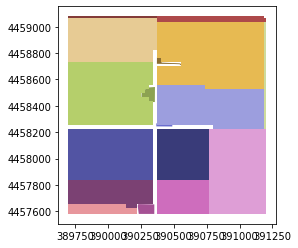

In [7]:
sqr = shapely.geometry.Polygon(vertices)
gs = gpd.GeoSeries([sqr])
gs.crs = {'init': 'epsg:32616'}
df = gpd.GeoDataFrame({'geometry': gs})
df.crs = shp.crs
intersection = gpd.overlay(df, shp, how='intersection')
ax = intersection.plot(cmap='tab20b')

In [8]:
def transform_pix(img, nodata=255, border_pix=2000):
    m = np.copy(img)
    row = m.shape[1]
    col = m.shape[2]
    for y in range(0, col):
        for x in range(0, row):
            if m[0, x, y] != nodata:
                # border
                if x == 0 or y == 0 or x == row-1 or y == col-1: 
                    m[0, x, y] = border_pix
                # top
                if x > 0 and m[0, x-1, y] == nodata: 
                    m[0, x, y] = border_pix
                # bottom
                if x < row-1 and m[0, x+1, y] == nodata:
                    m[0, x, y] = border_pix
                # left
                if y > 0 and m[0, x, y-1] == nodata:
                    m[0, x, y] = border_pix
                # right
                if y < col-1 and m[0, x, y+1] == nodata:
                    m[0, x, y] = border_pix
    return m

In [9]:
cp = np.zeros(rst.read(1).shape, dtype=np.int16)
for x in shp.itertuples():
    crp_img, crp_trans = mask(rst, [x.geometry], crop=True, nodata=255)
    t_img = transform_pix(crp_img)
    t_img = t_img.reshape((t_img.shape[1], t_img.shape[2]))
    it = np.nditer(t_img, flags=["multi_index"])
    while not it.finished:
        j, i = it.multi_index
        y, x = ~rst.transform * crp_trans * (i, j)
        if it[0] == 2000:
            cp[int(x), int(y)] = 1 #it[0]
        it.iternext()

In [10]:
profile = rst.profile
with rasterio.open("./data/generated/bordered.tif", "w", **profile) as dst:
    dst.write(cp, 1)

In [13]:
#hk = rasterio.open("./data/generated/bordered.tif")
#show(hk.read(1)[1000:1050, 500:550])
#show(img24)
#intersection.plot(cmap='tab20b')

In [14]:
#intersection.iloc[7].geometry
#show(cp[1200:1250, 1200:1250])
#show(img24)
#intersection.plot(cmap='tab20b')

In [52]:
cv_img = cv.imread('./data/generated/bordered.tif', 2)
crp = cv_img[1000:1050, 1000:1050]
kernel = np.ones((5, 5))
erode = cv.erode(crp, kernel, iterations=1)

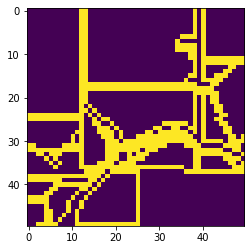

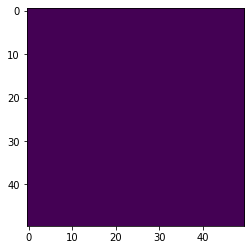

In [51]:
show(crp)
show(erode)

In [28]:
with rasterio.open("./data/generated/eroded.tif", "w", **profile) as dst:
    dst.write(img, 1)
#cv.imshow('Erosion', erosion)